In [1]:
!pip install facenet_pytorch --quiet

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import cv2


from facenet_pytorch import MTCNN

### Load data

In [3]:
# функция распознования класса из названия файла
classes = {
    'palm': 0,
    'l': 1,
    'fist': 2,
    'fist_moved': 3,
    'thumb': 4,
    'index': 5,
    'ok': 6,
    'palm_moved': 7,
    'c': 8,
    'down': 9,
}

# функция получения ключа по значению словаря classes
def get_key(value):
    for k, v in classes.items():
        if v == value:
            return k


def class_recognizer(x):
    if '01_palm' in x:
        return 'palm'
    elif '02_l' in x:
        return 'l'
    elif '03_fist' in x:
        return 'fist'
    elif '04_fist_moved' in x:
        return 'fist_moved'
    elif '05_thumb' in x:
        return 'thumb'
    elif '06_index' in x:
        return 'index'
    elif '07_ok' in x:
        return 'ok'
    elif '08_palm_moved' in x:
        return 'palm_moved'
    elif '09_c' in x:
        return 'c'
    elif '10_down' in x:
        return 'down'
    else:
        return None

In [4]:
from sklearn.model_selection import train_test_split

img_paths = sorted(Path('/kaggle/input/leapgestrecog/leapGestRecog/').glob('**/*.png'))
img_paths = list(map(str, img_paths))

df = pd.DataFrame(data=img_paths, columns={'path'})
df['class'] = df.apply(lambda x: class_recognizer(x['path']), axis=1)

train, test = train_test_split(df, random_state=3, test_size=0.5, shuffle=True)

In [5]:
train.sample(2)

,path,class
5857,/kaggle/input/leapgestrecog/leapGestRecog/02/1...,down
12671,/kaggle/input/leapgestrecog/leapGestRecog/06/0...,fist_moved


In [6]:
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()


class GestureDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.preprocess = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = classes[self.data['class'].iloc[idx]]
        img = Image.open(self.data['path'].iloc[idx]).convert('RGB')

        if self.preprocess:
            img = self.preprocess(img)

        else:
            img = tt.Resize((224, 224), interpolation=tt.InterpolationMode.BILINEAR)(img)
            img = tt.ToTensor()(img)
            img = tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            
        return img, label

In [7]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_dataset = GestureDataset(train, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = GestureDataset(test, transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([3, 224, 224])
tensor(7) palm_moved


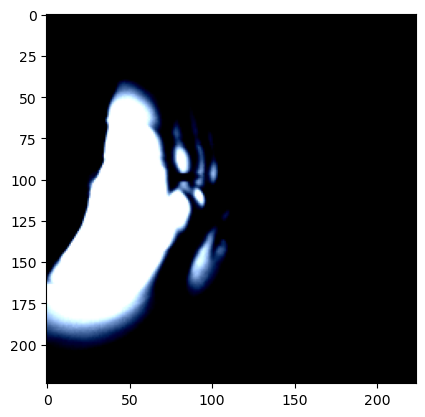

In [9]:
for img, label in train_loader:
    print(img[0].shape)
    plt.imshow(img[0].permute(1, 2, 0))
    print(label[0], get_key(label[0]))
    break

torch.Size([3, 224, 224])
tensor(7) palm_moved


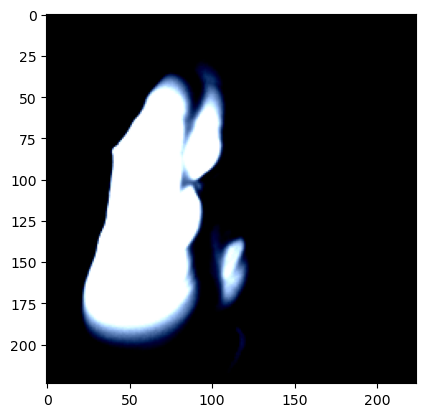

In [10]:
for img, label in test_loader:
    print(img[0].shape)
    plt.imshow(img[0].permute(1, 2, 0))
    print(label[0], get_key(label[0]))
    break

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:32], nrow=4).permute(1, 2, 0))
        break

torch.Size([3, 224, 224])


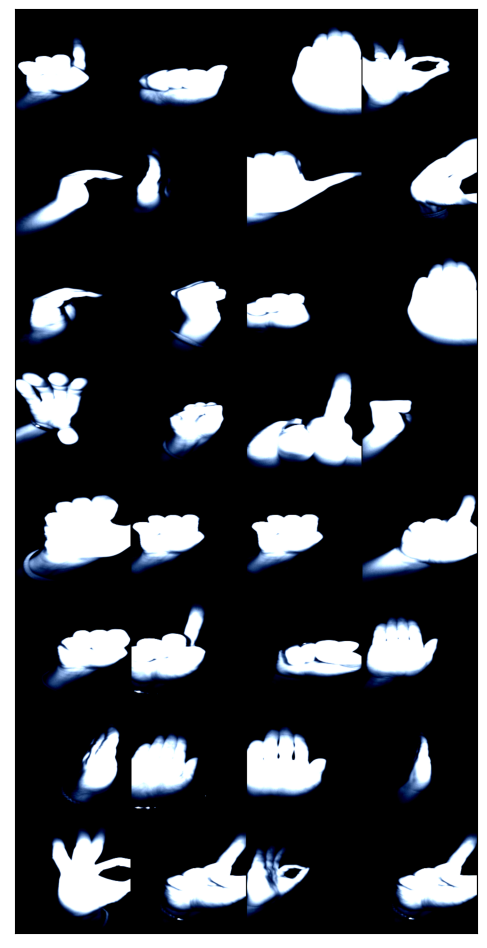

In [12]:
show_batch(train_loader)

### Symbol recognition

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [14]:
resnet = models.resnet18(weights=weights)
resnet.fc = nn.Linear(512, 10, bias=True)

In [15]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
epochs = 3
lr = 0.0001
resnet = resnet.to(device)
optimizer = torch.optim.Adam(params=resnet.parameters('fc'), lr=lr)
criterion = nn.CrossEntropyLoss()

In [19]:
from tqdm import tqdm


losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    resnet.train()
    running_loss, running_total, running_right = 0.0, 0.0, 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_total += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        epoch_loss.append(loss.item())
        
    test_running_loss, test_running_right, test_running_total = 0.0, 0.0, 0.0
    test_epoch_loss = []
    for batch_idx, (data, labels) in tqdm(enumerate(test_loader)):
        resnet.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = resnet(data)
        loss = criterion(outputs, labels)
        
        test_running_loss += loss.item()
        test_running_total += len(labels)
        test_running_right += (labels == torch.max(outputs, 1)[1]).sum()
        test_epoch_loss.append(loss.item())
        
    print(f'Epoch {epoch+1}, accuracy: {running_right / running_total}, test accuracy: {test_running_right / test_running_total}')    
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}, test loss: {np.mean(test_epoch_loss)}')
    losses.append(epoch_loss)
    test_losses.append(test_epoch_loss)
    torch.save(resnet, f'./model_{epoch}.pth')

313it [01:23,  3.77it/s]
313it [01:10,  4.45it/s]


Epoch 1, accuracy: 0.981499969959259, test accuracy: 1.0
Epoch 1, loss: 0.08754722579656103, test loss: 0.001438406517561049


81it [00:21,  3.69it/s]


KeyboardInterrupt: 

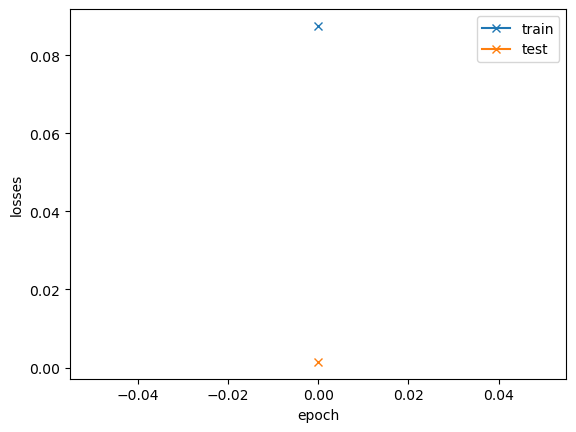

In [20]:
loss = [np.mean(loss) for loss in losses]
test_loss = [np.mean(loss) for loss in test_losses]
plt.plot(loss, '-x', label='train')
plt.plot(test_loss, '-x', label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('losses');

In [25]:
torch.save(resnet, './model.pth')

net = torch.load('./model.pth')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
img = Image.open('/kaggle/input/photo/photo.png').convert('RGB')
# print(img.shape)
img = tt.ToTensor()(img)
img = preprocess(img).to(device)
net.eval()
outputs = net(img[None, ...])
get_key(outputs[0].argmax())

'ok'

In [27]:
outputs

tensor([[ 0.3120, -0.6120, -0.2384,  0.3782, -1.6420, -1.4179,  2.4747, -0.7586,
         -0.2865,  1.8140]], device='cuda:0', grad_fn=<AddmmBackward0>)

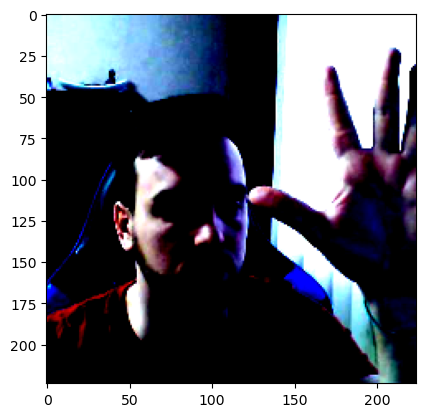

In [28]:
plt.imshow(img.permute(1, 2, 0).cpu())
plt.show()

In [29]:
outputs

tensor([[ 0.3120, -0.6120, -0.2384,  0.3782, -1.6420, -1.4179,  2.4747, -0.7586,
         -0.2865,  1.8140]], device='cuda:0', grad_fn=<AddmmBackward0>)